# Notebook for Exploring smFISH Data Analysis
1. Parse .npz files
2. Visualize detections

## Parse .npz files

In [ ]:
import numpy as np
import pandas as pd
import os

# build a dataframe from .npz files
indir = 'detections/all_timepoints_threshold_150'
infiles = [x for x in os.listdir(indir) if x.endswith('.npz')]

# prepare buckets for the data
file_name = []
ch = []
strain = []
time = []
treatment = []
total_vRNAs = []
cytosolic_RNAs = []
repSites = []
mol_per_repSite = []

# parse .npz files and add data to lists
# specify different timepoints
times = ['2h', '6h', '8h', '24h']

# loop through directory
for file in infiles:
    
    # specify time points
    for t in times:
        
        # load data
        data = np.load(os.path.join(indir, file))

        # add data to lists
        file_name.append(file)
        total_vRNAs.append(data['rna_coord'].shape[0]+np.sum(data['foci'][:,4]))
        cytosolic_RNAs.append(data['rna_coord'].shape[0])
        repSites.append(data['foci'].shape[0])
        mol_per_repSite.append(np.mean(data['foci'][:,4]))

        # specify treatments and strains
        if 'MOCK' in file:
            strain.append('None')
            time.append(t.split('h')[0])
            treatment.append('MOCK')
        if 'INF' in file:
            strain.append('B117')
            time.append(t.split('h')[0])
            treatment.append('INF')
        if 'RDV' in file:
            strain.append('B117')
            time.append(t.split('h')[0])
            treatment.append('RDV')
        if 'ch3' in file:
            ch.append(3)
        if 'ch4' in file:
            ch.append(4)

# create a dataframe from the lists
data_tall = pd.DataFrame(list(zip(file_name, ch, strain, time, treatment, total_vRNAs,
                            cytosolic_RNAs, repSites, mol_per_repSite)),
            columns =['file_name', 'ch', 'strain', 'time', 'treatment', 'total_vRNAs',
                            'cytosolic_RNAs', 'repSites', 'mol_per_repSite'])

# save dataframe
data_tall.to_csv('Data_summary.csv')
print('finished')

# Visualize the Results

## Read .npz files

CoV-FISH-10_Vero_2h_B117_INF_R1_00001_ch3_results_cell_5.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 

 number of rna 66
 number of foci 4


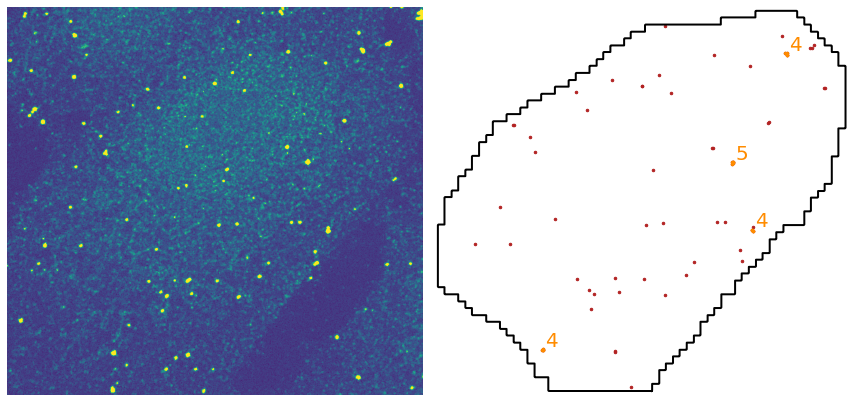

CoV-FISH-10_Vero_2h_B117_INF_R1_00001_ch3_results_cell_4.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 

 number of rna 86
 number of foci 1


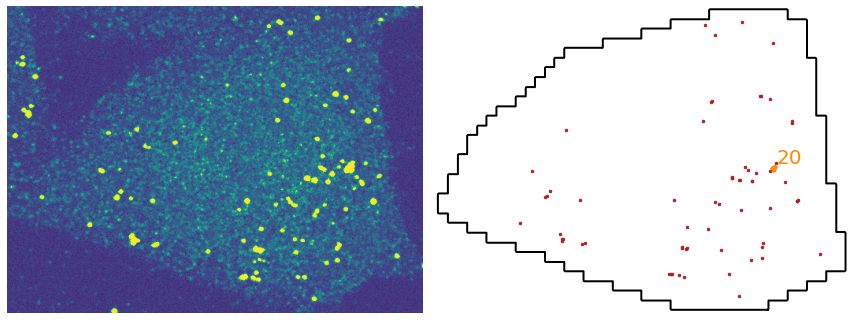

CoV-FISH-10_Vero_2h_B117_INF_R1_00001_ch3_results_cell_0.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 

 number of rna 131
 number of foci 1


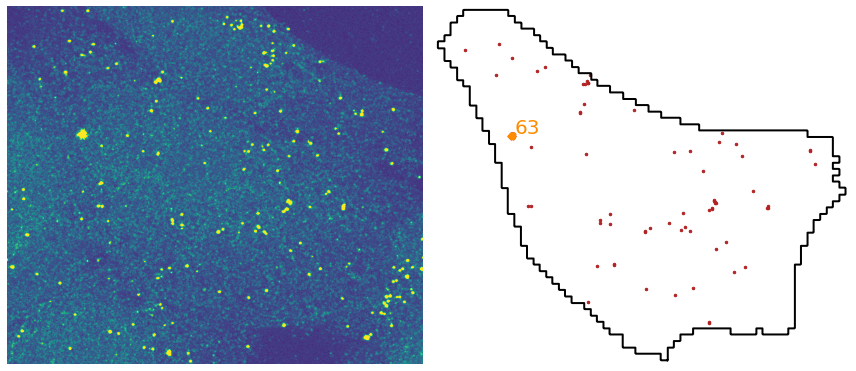

CoV-FISH-10_Vero_2h_B117_INF_R1_00001_ch3_results_cell_1.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 

 number of rna 172
 number of foci 6


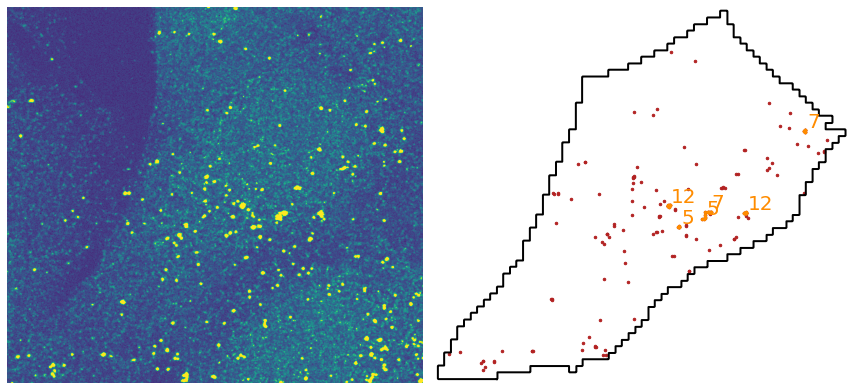

CoV-FISH-10_Vero_2h_B117_INF_R1_00001_ch3_results_cell_3.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 

 number of rna 329
 number of foci 16


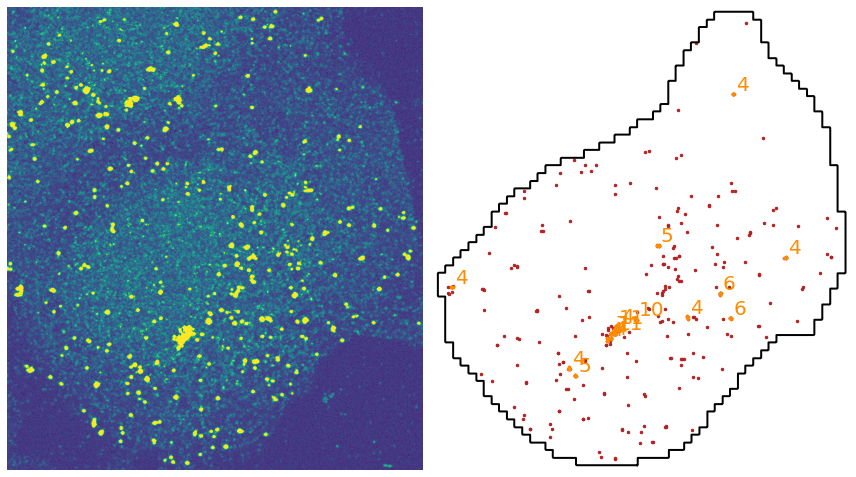

CoV-FISH-10_Vero_2h_B117_INF_R1_00001_ch3_results_cell_2.npz
Available keys: cell_id, bbox, cell_coord, cell_mask, rna_coord, foci, image, smfish 

 number of rna 76
 number of foci 2


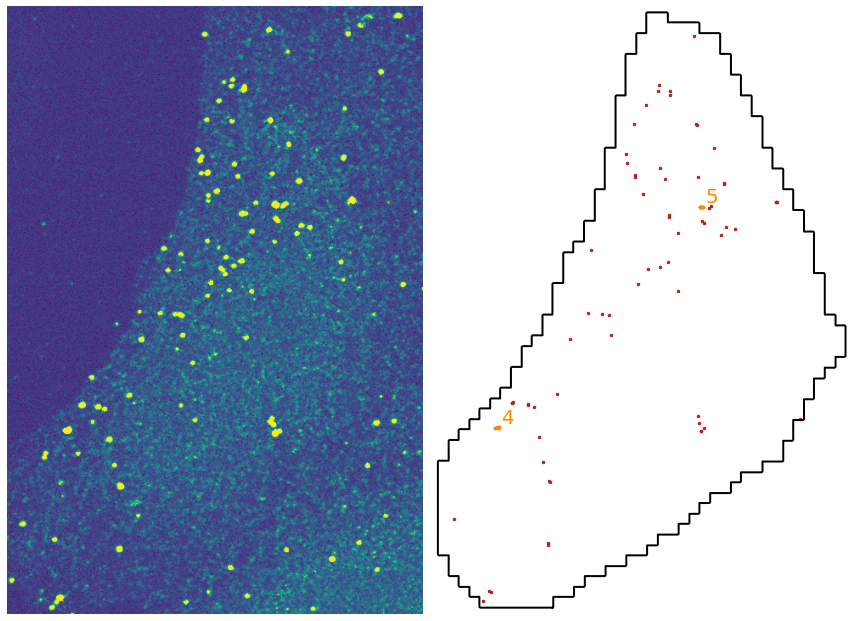

In [14]:
import os
import numpy as np
import bigfish.stack as stack
import bigfish.plot as plot

# load single cell data
indir = 'detections'
keyword = 'CoV-FISH-10_Vero_2h_B117_INF_R1_00001_ch3_results_cell'
infiles = [x for x in os.listdir(indir) if x.endswith('.npz') and keyword in x]

def plot_cells():
    # get cell results
    cell_mask = data["cell_mask"]
    cell_coord = data["cell_coord"]
    rna_coord = data["rna_coord"]
    foci_coord = data["foci"]
    image_contrasted = data["image"]
    print("\r number of rna {0}".format(len(rna_coord)))
    print("\r number of foci {0}".format(len(foci_coord)))

    # plot cell
    plot.plot_cell(
        ndim=3, cell_coord=cell_coord, rna_coord=rna_coord, 
        foci_coord=foci_coord, image=image_contrasted, 
        cell_mask=cell_mask, framesize=(12, 10))
    
for file in infiles:
    path = os.path.join(indir, file)
    print (file)
    data = stack.read_cell_extracted(path, verbose=True)
    rna_coord = data["rna_coord"]
    foci_coord = data["foci"]
    plot_cells()


# Analyze single file to optimize threshold parameter

OMERO finished 5.254923105239868 sec
data import finished  148.9402050971985 sec
>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 3.75s; flow+mask computation 0.73
estimated masks for 1 image(s) in 4.64 sec
>>>> TOTAL TIME 4.64 sec
cellpose finished  153.64329409599304 sec
LoG filter finished  347.1404609680176 sec
spot detection finished  354.2070698738098 sec
spot decomposition finished  367.22546005249023 sec


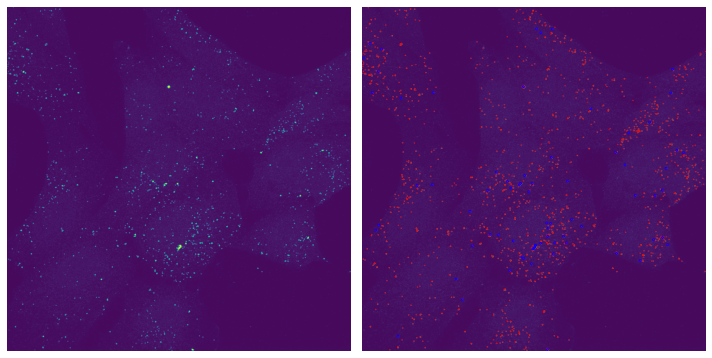

bigfish analysis took  375.88777709007263 sec


In [46]:
import getpass
import omero
from omero.gateway import BlitzGateway
import os
import multiprocessing as mp
from multiprocessing import Process
import os
import threading
import time
from skimage.morphology import white_tophat, black_tophat, disk
from scipy import ndimage
import numpy as np
import tifffile
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection
from cellpose import models, io
import yaml

start_time = time.time()

# load config file
with open('smFISH_analysis.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# setup OMERO connection
conn = BlitzGateway(config['user'], config['PASS'],
        port=4064, group=config['group'], host='omero1.bioch.ox.ac.uk') #davisgroup
conn.connect()
conn.SERVICE_OPTS.setOmeroGroup(-1)

# helper function to display OMERO objects
def print_obj(obj, indent=0):
    print ("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName()))

# keep connection to OMERO alive
def keep_connection_alive():
    while True:
        conn.keepAlive()
        time.sleep(60)

th_ka = threading.Thread(target = keep_connection_alive)
th_ka.daemon = True
th_ka.start()

# hard-code the output directory and datasetId
if not os.path.exists('detections'):
    os.makedirs('detections')
path_output = 'detections'

# get OMERO image
imageId = config['imageId']
img = conn.getObject('Image', imageId)
for orig_file in img.getImportedImageFiles():
    image = orig_file.getName()
chan = config['smFISH_ch1']
ch = config['smFISH_ch1_name']

print ("OMERO finished", time.time() - start_time, "sec")

# helper function to display OMERO objects
def print_obj(obj, indent=0):
    print ("""%s%s:%s  Name:"%s" (owner=%s)""" % (
        " " * indent,
        obj.OMERO_CLASS,
        obj.getId(),
        obj.getName(),
        obj.getOwnerOmeName()))

# get acquisition parameters
def img_params(file_name):
    voxel_size_z = config['instr1_voxel_size_z']
    voxel_size_yx = config['instr1_voxel_size_yx']
    return voxel_size_z, voxel_size_yx

# calculate psf (thank you MK), with edit for consistent nomenclature
def calculate_psf(voxel_size_z, voxel_size_yx, Ex, Em, NA, RI, microscope):
    '''
    Use the formula implemented in Matlab version (sigma_PSF_BoZhang_v1)
    to calculate the theoretical PSF size.
    '''
    if microscope == 'widefield':
        psf_yx = 0.225*Em/NA
        psf_z = 0.78*RI*Em/(NA**2)
    elif microscope in {'confocal', 'nipkow'}:
        psf_yx = 0.225/NA*Ex*Em/np.sqrt(Ex**2 + Em**2)
        psf_z = 0.78*RI/NA**2*Ex*Em/np.sqrt(Ex**2 + Em**2)
    else:
        print(f'microscope={microscope} is not a valid option')
        sys.exit()
    return psf_z, psf_yx

# convert OMERO Image object into np array
def get_z_stack(img, c, t=0):
    z_range = range(0, img.getSizeZ(), 1)
    zct_list = [(z, c, t) for z in z_range]
    pixels = img.getPrimaryPixels()
    return np.array(list(pixels.getPlanes(zct_list)))

# subtract background
def subtract_background(image, radius=config['bg_radius'], light_bg=False):
    str_el = disk(radius) #you can also use 'ball' here to get a slightly smoother result at the cost of increased computing time
    if light_bg:
        return black_tophat(image, str_el)
    else:
        return white_tophat(image, str_el)
    
# segment with cellpose
if config['cp_search_string'] in image:
    seg_img = np.max(get_z_stack(img,config['dapi_ch']),0)
    seg_img = np.clip(seg_img,0,config['cp_clip'])
    print ("data import finished ", time.time() - start_time, "sec")

else:
    seg_img = np.max(get_z_stack(img,config['mask_ch']),0)
    seg_img = ndimage.median_filter(seg_img, size=config['median_filter'])
    print ("data import finished ", time.time() - start_time, "sec")

model = models.Cellpose(gpu=config['gpu'], model_type='cyto')
channels = [0,0]
masks, flows, styles, diams = model.eval(seg_img, channels=channels, diameter=config['diameter'], do_3D=config['do_3D'])
print ("cellpose finished ", time.time() - start_time, "sec")

# detect spots
rna = get_z_stack(img, chan)

# subtract background
rna_no_bg = []
for z in rna:
    z_no_bg = subtract_background(z)
    rna_no_bg.append(z_no_bg)
rna = np.array(rna_no_bg)

# calculate_psf(voxel_size_z, voxel_size_yx, 570, 610, 1.4, 1.364, 'confocal')[0]
psf_z = calculate_psf(img_params(image)[0], img_params(image)[1],
                      config['ex'], config['em'], config['NA'], config['RI'], config['microscope'])[0]
psf_yx = calculate_psf(img_params(image)[0], img_params(image)[1],
                      config['ex'], config['em'], config['NA'], config['RI'], config['microscope'])[1]
sigma_z, sigma_yx, sigma_yx = detection.get_sigma(img_params(image)[0],
                                img_params(image)[1], psf_z, psf_yx)
sigma = (sigma_z, sigma_yx, sigma_yx)

# LoG filter
rna_log = stack.log_filter(rna, sigma)
print ("LoG filter finished ", time.time() - start_time, "sec")

# local maximum detection
mask = detection.local_maximum_detection(rna_log, min_distance=sigma)

# thresholding
threshold = config['thresh_smFISH_ch1']
#threshold = detection.automated_threshold_setting(rna_log, mask)
#    threshold = config['threshold']
spots, _ = detection.spots_thresholding(rna_log, mask, threshold)
print ("spot detection finished ", time.time() - start_time, "sec")

# detect and decompose clusters
spots_post_decomposition, clusters, reference_spot = detection.decompose_cluster(
rna, spots,
img_params(image)[0], img_params(image)[1], psf_z, psf_yx,
alpha=0.7,  # alpha impacts the number of spots per cluster
beta=1)   # beta impacts the number of detected clusters

# separate spots from clusters
radius = config['bf_radius']
nb_min_spots = config['nb_min_spots']
spots_post_clustering, foci = detection.detect_foci(spots_post_decomposition,
    img_params(image)[0], img_params(image)[1], radius, nb_min_spots)
print ("spot decomposition finished ", time.time() - start_time, "sec")

# extract cell level results
image_contrasted = stack.rescale(rna, channel_to_stretch=0)
image_contrasted = stack.maximum_projection(image_contrasted)
rna_mip = stack.maximum_projection(rna)

fov_results = stack.extract_cell(
    cell_label=masks.astype(np.int64),
    ndim=3,
    rna_coord=spots_post_clustering,
    others_coord={"foci": foci},
    image=image_contrasted,
    others_image={"smfish": rna_mip})

# plot
(radius_z, radius_yx, radius_yx) = detection.get_radius(config['instr2_voxel_size_z'], config['instr2_voxel_size_yx'], psf_z, psf_yx)

plot.plot_detection(rna_mip, 
                spots=[spots_post_decomposition, foci[:, :3]], 
                shape=["circle", "polygon"], 
                radius=[radius_yx, radius_yx*2], 
                color=["red", "blue"],
                linewidth=[1, 2], 
                fill=[False, True], 
                framesize=(10, 8), 
                contrast=True)
# save results
#for i, cell_results in enumerate(fov_results):
#    path = os.path.join(path_output, image.split('.')[0]+'_'+ch+'_results_cell_{0}.npz'.format(i))
#    stack.save_cell_extracted(cell_results, path)

print ("bigfish analysis took ", time.time() - start_time, "sec")
    

In [48]:
rna.shape

(28, 2048, 2048)

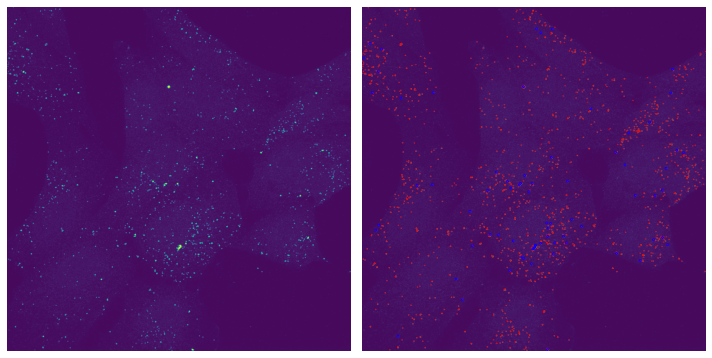

In [47]:
# plot
(radius_z, radius_yx, radius_yx) = detection.get_radius(config['instr2_voxel_size_z'], config['instr2_voxel_size_yx'], psf_z, psf_yx)

plot.plot_detection(rna_mip, 
                spots=[spots_post_decomposition, foci[:, :3]], 
                shape=["circle", "polygon"], 
                radius=[radius_yx, radius_yx*2], 
                color=["red", "blue"],
                linewidth=[1, 2], 
                fill=[False, True], 
                framesize=(10, 8), 
                contrast=True)

# Show LoG image

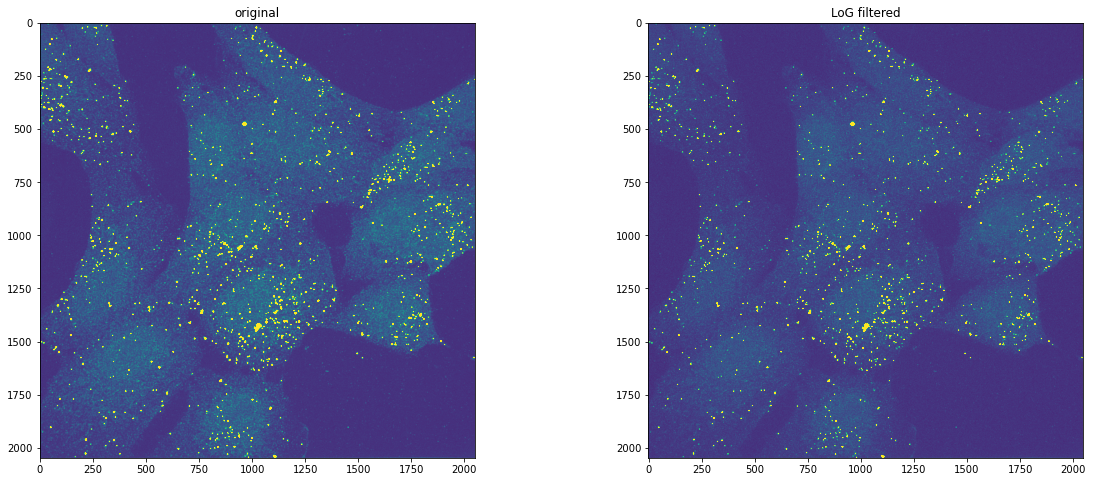

In [44]:
import matplotlib.pyplot as plt
from PIL import Image

img_max = Image.fromarray(np.max(rna,0))
img_LoG = stack.log_filter(rna, sigma)
img_LoG_max = np.max(img_LoG,0)
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
ax[0].set_title('original')
ax[0].imshow(np.max(rna,0), vmin=0, vmax=139)
ax[1].set_title('LoG filtered')
ax[1].imshow(np.max(rna_log, 0), vmin=0, vmax=139)
im = Image.fromarray(img_LoG_max)
img_max.save('img_max.tif')
im.save('im_LoG.tif')
plt.show()